In [1]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp


import itertools
from collections import defaultdict
import collections

from functools import reduce

from multiprocess import Pool
from functools import partial
import numpy as np

import itertools 
from itertools import islice
import games

import cpb
import bpm
import random_algo

import plotly.graph_objects as go
import TSPM

import cpb_gaussian
import PM_DMED
import feedexp3_piccolboni
from math import exp, pow

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):

    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []

    for jobid in range(n_folds):

        p_min = np.random.uniform(0, 0.2)
        p_max = np.random.uniform(0.8,1.0)
        distributions.append( [p_min, p_max] )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,range(n_folds)) ) ) 

class Evaluation:

    def __init__(self, horizon, type ):
        self.horizon = horizon
        self.type = type

    def get_outcomes(self, game, job_id):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_outcome(self, game, job_id):
        outcome = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ) )
        return outcome

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def my_gauss(x, sigma=1, h=1, mid=0):
        variance = pow(sigma, 2)
        return h * exp(-pow(x-mid, 2)/(2*variance))

    def attack_seasons(self, p_min, p_max, horizon, nb_changes = 3):
        # res = False
        # while res == False:
        #     lengths = np.array( np.cumsum(   np.random.normal(horizon/nb_changes, 50, 3)  ) ,dtype = int )
        #     if lengths[-1]<horizon:
        #         res = True
        # lengths = lengths.tolist()
        # lengths.append(horizon)
        lengths = [250,500,750, horizon]

        init_outcome = 0 # np.random.randint(0,2,1)[0]
        outcomes = []
        for i in range(nb_changes+1):
            if i == 0:
                outcomes.append(init_outcome)
            else:
                outcomes.append(1-outcomes[i-1])

        seq = [  ]
        idx = 0
        for i in range(horizon):
            if i >= lengths[idx]:
                idx +=1

            if i < lengths[idx]  and outcomes[idx] == 0:
                seq.append(p_min)
            elif i < lengths[idx] and outcomes[idx] == 1:
                seq.append(p_max)
                
        return seq

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, jobid = job
        np.random.seed(jobid)

        action_counter = np.zeros( (game.n_actions, self.horizon) )
        cum_regret = []

        if self.type == 'constant':
            seq = [ distribution[0] for i in range(self.horizon) ]
        if self.type == 'linear':
            seq = np.geomspace(distribution[0], distribution[1], num=self.horizon)
        elif self.type == 'exp':
            seq = np.linspace(distribution[0], distribution[1], num=self.horizon)
        elif self.type == 'gaussian':
            x =  np.linspace(-20, 20, 1000) #np.linspace(norm.ppf(0.01,500, 1), norm.ppf(0.99,500, 1), 1000)
            seq = [ my_gauss(i, sigma=3, h=b, mid=0) for i in x ]
        elif self.type == 'realistic':
            seq = self.attack_seasons(distribution[0],distribution[1],1000)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome_distribution = {'spam':seq[t], 'ham':1-seq[t]}
            game.set_outcome_distribution( outcome_distribution )
            outcome = self.get_outcome(game, jobid)

            #print('t', t, 'action', action, 'outcome', outcome, )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, None, t)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] + 1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        # regret = []
        # for t in range(self.horizon):
        #     regret.append(  self.delta_t( game, summary, t )  @ action_counter[:,t] )
            # cum_regret.append(  game.LossMatrix[action,outcome] - min( game.LossMatrix[...,outcome ] )  )
            
        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        
        return regret #np.cumsum(cum_regret)

1000


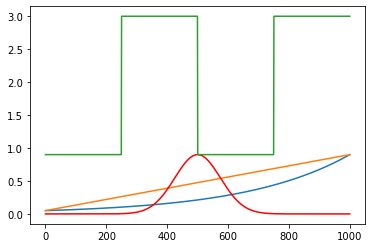

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

a = 0.05
b = 0.9

seq = np.geomspace(a,b, num=1000)
plt.plot(seq)

seq = np.linspace(a,b, num=1000)
plt.plot(seq)


def my_gauss(x, sigma=1, h=1, mid=0):
    from math import exp, pow
    variance = pow(sigma, 2)
    return h * exp(-pow(x-mid, 2)/(2*variance))


x =  np.linspace(-20, 20, 1000) #np.linspace(norm.ppf(0.01,500, 1), norm.ppf(0.99,500, 1), 1000)
seq = [ my_gauss(i, sigma=3, h=b, mid=0) for i in x ]
plt.plot(range(1000), seq,  'r-',  label='norm pdf')


def attack_seasons(self, p_min, p_max, horizon, nb_changes = 3):
    # res = False
    # while res == False:
    #     lengths = np.array( np.cumsum(   np.random.normal(horizon/nb_changes, 50, 3)  ) ,dtype = int )
    #     if lengths[-1]<horizon:
    #         res = True
    # lengths = lengths.tolist()
    # lengths.append(horizon)
    lengths = [250,500,750, horizon]

    init_outcome =  np.random.randint(0,2,1)[0]
    outcomes = []
    for i in range(nb_changes+1):
        if i == 0:
            outcomes.append(init_outcome)
        else:
            outcomes.append(1-outcomes[i-1])

    seq = [  ]
    idx = 0
    for i in range(horizon):
        if i >= lengths[idx]:
            idx +=1

        if i < lengths[idx]  and outcomes[idx] == 0:
            seq.append(p_min)
        elif i < lengths[idx] and outcomes[idx] == 1:
            seq.append(p_max)
            
    return seq

seq = attack_seasons(a,b,3,1000)
print(len(seq))
plt.plot(seq)

In [6]:


n_cores = 1
n_folds = 1
horizon = 1000

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 



outcome_distribution = [0.1077633468006714, 0.8922366531993287]
job = (outcome_distribution, 9 )

game =  games.label_efficient(  ) 
game.set_outcome_distribution( {'spam':outcome_distribution[0],'ham':outcome_distribution[1]} )
print('optimal action', game.i_star)

# print('optimal action', game.i_star)
alg = PM_DMED.PM_DMED(  game, horizon,) #cpb.CPB(  game, horizon,1.01) #TSPM.TSPM_alg(  game, horizon, 1)
task = Evaluation(horizon, 'easy')

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


optimal action 1
n-actions 3 n-outcomes 2 alphabet 3


UnboundLocalError: local variable 'seq' referenced before assignment

In [ ]:
n_cores = 16
n_folds = 50
horizon = 1000

# constant, linear, exp, gaussian, realistic

game = games.label_efficient(  )

algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon,),   

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

fig = go.Figure( )

final_regrets = []

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'realistic')
    # result = np.load('./results/label_efficient/drifts/{}_{}_{}_{}.npy'.format(type, horizon,n_folds,label) )
    final_regrets.append( result[:,-1] )
    regret =  np.mean(result, 0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    np.save('./results/label_efficient/drifts/{}_{}_{}_{}.npy'.format(type, horizon,n_folds,label), result)

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
# fig.show(legend=True)
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
# fig.write_image("./hard_LE.pdf")

fig.show()

fig.update_xaxes(type="log")
# fig.write_image("./hard_LE_log.pdf")
fig.show()
final_regrets = np.array(final_regrets)
final = [ ( np.argmin(final_regrets[:,i]), i) for i in range(n_folds) ]

In [ ]:
n_cores = 16
n_folds = 100
horizon = 5000
game = games.label_efficient(  )

algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon,),   

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

fig = go.Figure( )

final_regrets = []

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    # result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    result = np.load('./results/label_efficient/easy_{}_{}_{}.npy'.format(horizon,n_folds, label) )
    final_regrets.append( result[:,-1] )
    regret =  np.mean(result, 0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    # np.save('./results/label_efficient/easy_{}_{}_{}'.format(horizon,n_folds, label), result)

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 30] )
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./easy_LE.pdf")

fig.show()


fig.update_xaxes(type="log")
fig.write_image("./easy_LE_log.pdf")
fig.show()

final_regrets = np.array(final_regrets)
final = [ ( np.argmin(final_regrets[:,i]), i) for i in range(n_folds) ]

In [10]:
res = []
for i in range(n_folds):
    opt = min(final_regrets[:,i])
    vec = [ j == opt for j in final_regrets[:,i] ] 
    #if vec[1]==1 and vec[2] == 1:
    #    pass
    #else:
    res.append(  vec  )

#print( np.sum( res,0) )

diff = []
for i in range(n_folds):
    if res[i][1] >= res[i][2]:
        diff.append( i )

np.random.seed(1)
distributions = []
for jobid in range(n_folds):
    p = np.random.uniform(0.4, 0.5) 
    distributions.append( [p, 1-p] )

distributions_rand = np.array([ distributions[i] for i in diff ])
distributions_cbp = np.array([ distributions[i] for i in range(n_folds) if i not in diff ])
#print( len( diff ) )
print(np.mean(distributions_rand[:,0]), np.std(distributions_rand[:,0]) )
print(np.mean(distributions_cbp[:,0]), np.std(distributions_cbp[:,0]) )


0.456154090331781 0.03132638699822154
0.43466197585846006 0.024706747598054565


In [ ]:
fig.update_xaxes(type="log")
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence (log-scale)", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./easy_LE_log.pdf")
fig.show()

In [5]:
fig.write_image("./easy_LE.pdf")

